In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
raw_df['channel_type'].value_counts(dropna=False)

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
NaN        2910
Name: channel_type, dtype: int64

In [5]:
# заменем отсутствующие значения в столбце 'канал привлечения' на 'type6'
raw_df['channel_type'].fillna('type6', inplace=True)
raw_df['channel_type'].value_counts(dropna=False)

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
type6      2910
Name: channel_type, dtype: int64

In [6]:
num_customers = raw_df['cl_id'].nunique()
print(f'Количество уникальных клиентов: {num_customers}')

Количество уникальных клиентов: 5000


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
cl_ids_df = raw_df.drop_duplicates('cl_id', keep='first')
cl_ids_df.set_index('cl_id').head(1)

,PERIOD,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
cl_id,,,,,,,,,
0,01/10/2017,5200,type6,810,21OCT17:00:00:00,5023.0,POS,0,0.0


In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, 
                               random_state=42)

In [10]:
# cоздадим стратифицированную выборку на соснове катергорий транзакций и каналов привлечения.
for cl_ids_train, cl_ids_test in split.split(raw_df, raw_df[['trx_category', 'channel_type']]):
    train_df = raw_df[raw_df['cl_id'].isin(cl_ids_train)].copy()
    test_df = raw_df[raw_df['cl_id'].isin(cl_ids_test)].copy()
    
print("Total transactions in train dataset: ", len(train_df))
print("Total transactions in test dataset: ", len(test_df))

Total transactions in train dataset:  388552
Total transactions in test dataset:  101961


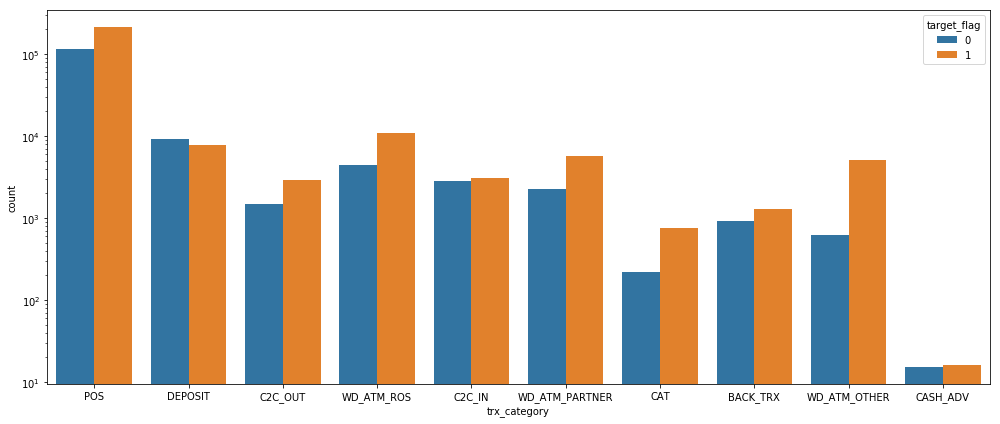

In [11]:
plt.figure(figsize = (14,6))
ax = sns.countplot(x = 'trx_category', hue='target_flag', data=train_df)
ax.figure.get_axes()[0].set_yscale('log')
plt.tight_layout()

Как видно, большинство операций проходят через POS терминал. Во всех остальных категориях - операций на порядок меньше (ось y - логарифмическая)

In [12]:
channel_type_df = raw_df.drop_duplicates('cl_id', keep='first')

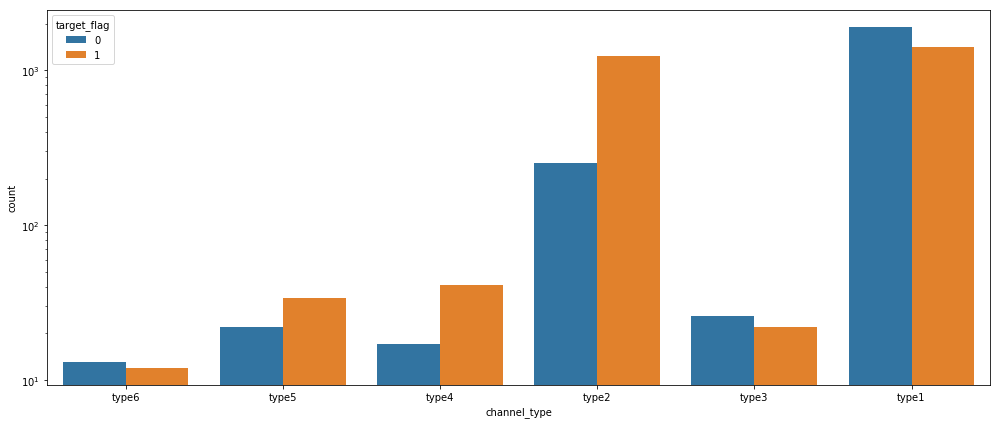

In [13]:
plt.figure(figsize = (14,6))
ax = sns.countplot(x = 'channel_type', hue='target_flag', data=cl_ids_df)
ax.figure.get_axes()[0].set_yscale('log')
plt.tight_layout()

Количество клиентов в зависимости от канала привлечения также существенно отличается (на графики ось y - логарифмическая).

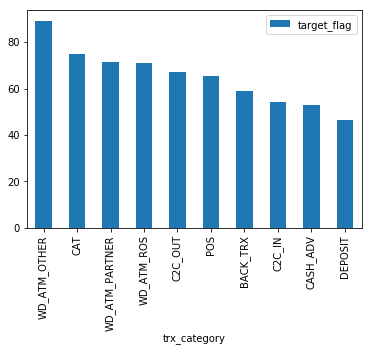

In [14]:
trx_category = (raw_df[['trx_category', 'target_flag']].groupby('trx_category').sum()
 /
raw_df[['trx_category', 'target_flag']].groupby('trx_category').count())*100

trx_category.sort_values('target_flag', ascending=False).plot(kind='bar')
# Доля оставшихся клиентов для разных категорий транзаций

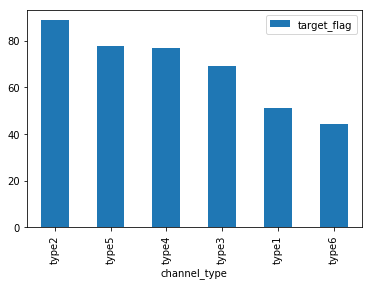

In [15]:
channel_df = (raw_df[['channel_type', 'target_flag']].groupby('channel_type').sum()
 /
raw_df[['channel_type', 'target_flag']].groupby('channel_type').count())*100

channel_df.sort_values('target_flag', ascending=False).plot(kind='bar')
# Доля оставшихся клиентов в зависимости от канала привлечения

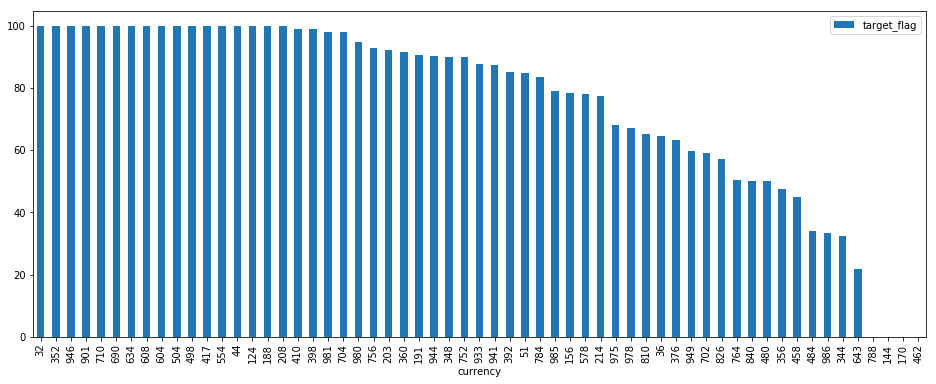

In [16]:
currency_df = (raw_df[['currency', 'target_flag']].groupby('currency').sum()
 /
raw_df[['currency', 'target_flag']].groupby('currency').count())*100
currency_df.sort_values('target_flag', ascending=False).plot(kind='bar', figsize=(16,6))

# Доля оставшихся клиентов в зависимости от используемых валют

In [17]:
train_df.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum'],
      dtype='object')

In [18]:
train_df['MCC'].value_counts().head()
# Топ 5 MCC кодов по количеству транзакций

5411    96017
6011    43415
5814    32558
5812    23487
5499    21415
Name: MCC, dtype: int64

5411 - Бакалейные магазины, супермаркеты<br>
6011 - Cнятие наличности<br>
5814 - Фастфуд

In [19]:
(train_df[['MCC', 'amount']].groupby('MCC').sum()
 /train_df['amount'].sum()*100
).sort_values('amount', ascending=False).head()
# Топ 5 MCC кодов по сумме транзакций (без учета курса валют) - в процентах от общей суммы всех транзакций

,amount
MCC,
6011,52.668645
6012,6.580724
5411,4.727808
7011,3.883659
4829,3.101121


Что касается суммы транзакций, картина другая:<br>
6011 - Cнятие наличности<br>
6012 - Финансовые институты – торговля и услуги<br>
5411 - Бакалейные магазины, супермаркеты

In [20]:
from datetime import datetime, timedelta
import requests
# !pip install pycbrf
from pycbrf.toolbox import ExchangeRates

In [21]:
def get_woe(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [22]:
woe_columns = ['MCC', 'channel_type']

In [23]:
for col in woe_columns:
    get_woe(train_df, test_df, col, 'target_flag')

In [24]:
train_df.head(1)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,MCC_woe,channel_type_woe
0,01/10/2017,0,5200,type6,810,21OCT17:00:00:00,5023.0,POS,0,0.0,-0.654028,-1.226953


In [25]:
def working_dates(df):
    '''
    Функция возвращает словарь, где ключ - это дата в формате datetime.date(),
    а значение - это 1, если дата рабочий день и 0, если выходной или праздничный. 
    В функцию передается dataframe с колонкой 'datetime' в формате datetime.
    '''
    first_date = df['datetime'].min()
    last_date = df['datetime'].max()
    work_days = {}
    day = first_date
    while day <= last_date+timedelta(days=1):
        work_days[day.date()] = abs(int(requests.get(
            f"https://isdayoff.ru/{day.strftime('%Y%m%d')}").text) - 1)
        day += timedelta(days=1)
    return work_days

In [26]:
def currencies_sets(df):
    '''
    Функция возвращает 2 множества с кодами валют:
    - по курсам которых нет данных,
    - по курсам которых есть данные.
    '''
    currencies_num = df['currency'].unique()
    rates = ExchangeRates(
        df['datetime'].iloc[0].strftime('%Y-%m-%d'))
    # список нумерных кодов валют, по курсам которых нет данных
    no_rate_cur_lst = []
    # список нумерных кодов валют, по курсам которых есть данные
    cur_with_rate_lst = []
    for cur in currencies_num:
        try:
            rates[str(cur)]
            cur_with_rate_lst.append(cur)
        except:
            no_rate_cur_lst.append(cur)
    return set(cur_with_rate_lst), set(no_rate_cur_lst)

In [27]:
def monthly_rates_dict(df, rate_cur_set):
    '''
    Функция возвращает словарь, где ключ - это 15-е число каждого месяца из периода
    между min и max датой в колонке 'datetime' переданного в ф-ию dataframe,
    а значение - это словарь с ключом - код валюты, значением - курсом валюты.
    '''
    first_date = df['datetime'].min().replace(hour=12)
    last_date = df['datetime'].max().replace(hour=12)
    # 
    month_year_rates = {}
    day = first_date
    while day <= last_date+timedelta(days=15):
        day_str = day.strftime('%Y-%m-15')
        month_year_rates[day_str] = {}
        rate = ExchangeRates(day_str)
        for cur in rate_cur_set:
            try:
                month_year_rates[day_str][cur] = float(rate[str(cur)].value)
            except:
                month_year_rates[day_str][cur] = 1.0
        month = day.month
        year = day.year
        if month == 12:
            day = day.replace(month=1, year=year+1)
        else:
            day = day.replace(month=month+1)
    return month_year_rates

In [28]:
def create_new_columns(df):
    '''
    Функция создает в переданном df новые столбцы:
    - 'datetime' (столбец 'TRDATETIME', преобразованный в формат datetime),
    - 'date' (столбец 'datetime', преобразованный в формат date)
    - 'work_days' (1, если рабочий день, 0 если выходной или праздничный),
    - 'rates' (курс валюты, если по валюте есть данные, 1 - если рубль или нет данных),
    - 'amount_rub' (сумма транзакции в рублях)
    - 'MCC_woe'
    - 'channel_type_woe'
    '''
    df['datetime'] = df['TRDATETIME'].apply(
        lambda x: datetime.strptime(x, '%d%b%y:%H:%M:%S'))
    df['date'] = df['datetime'].apply(lambda x: x.date())
    work_days = working_dates(df)
    df['work_days'] = df['datetime'].apply(
    lambda x: work_days[x.date()])
    rate_cur_set, no_rate_cur_set = currencies_sets(df)
    month_year_rates = monthly_rates_dict(df, rate_cur_set)
    df['rates'] = df[['datetime', 'currency']].apply(
    lambda x: month_year_rates[x['datetime'].strftime(
        '%Y-%m-15')][x['currency']] if (x['currency'] 
        not in no_rate_cur_set) else 1, axis=1)
    df['amount_rub'] = df['amount']*df['rates']
    df.drop(['target_sum', 'TRDATETIME', 'PERIOD'], axis=1, 
    inplace=True, errors='ignore')

In [29]:
create_new_columns(train_df)

In [30]:
create_new_columns(test_df)

In [31]:
week_days = {0: 'пн', 1: 'вт', 2: 'ср', 3: 'чт', 4: 'пт', 5: 'сб', 6: 'вс'}

In [32]:
train_df['week_day'] = train_df['datetime'].apply(lambda x: week_days[x.weekday()])

In [33]:
train_df['hour'] = train_df['datetime'].apply(lambda x: x.hour)

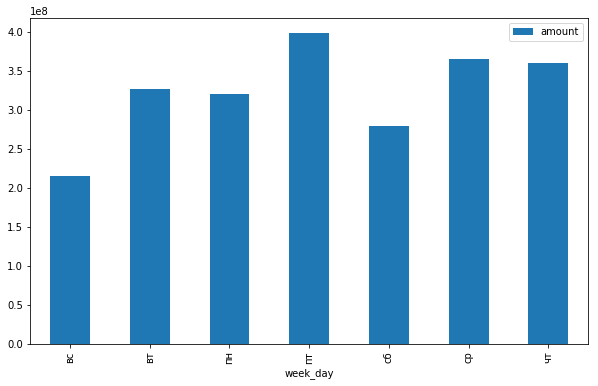

In [42]:
# сумма трат по дням недели
train_df[['week_day', 'amount']].groupby('week_day').sum().plot(kind='bar', figsize=(10,6))

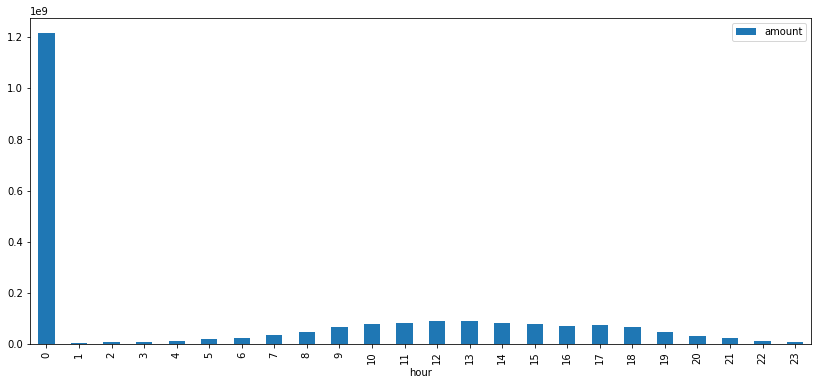

In [43]:
# сумма трат по часам
train_df[['hour', 'amount']].groupby('hour').sum().plot(kind='bar', figsize=(14,6))

In [44]:
# явный выброс для 0 часов. В целом распределение похоже на нормальное.

In [45]:
train_df.drop(['week_day', 'hour'], axis=1, inplace=True)

In [46]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [47]:
from functools import reduce

def create_features_df(df):
    '''
    Возвращает dataframe с фичами для обучения
    '''
    # создаем dataframe: cl_id: продолжительность участия в программе
    num_days_df = df[['cl_id', 'datetime']].groupby('cl_id').agg(
    ['min', 'max']).diff(axis=1)['datetime'] + timedelta(days=1)
    num_days_df.drop('min', axis=1, inplace=True)
    num_days_df.columns = ['days']
    num_days_df['days'] = num_days_df['days'].dt.days
    # создаем dataframe: cl_id: отношение суммы транзакций в рабочие дни
    # к сумме транзакций за все дни.
    work_sum_per_all_df = (
        df[df['work_days']==1][['cl_id', 'amount_rub']].groupby(['cl_id']).sum()
            /
        df[['cl_id', 'amount_rub']].groupby(['cl_id']).sum()
        )
    work_sum_per_all_df.fillna(0, inplace=True)
    work_sum_per_all_df.columns = ['work_sum_per_all']
    # создаем dataframe: cl_id: средняя сумма трат в день
    sum_per_day_df = pd.DataFrame(
        df[['cl_id', 'amount_rub']].groupby('cl_id').sum()['amount_rub']
            /
        df[['cl_id', 'date']].groupby('cl_id')['date'].nunique())
    sum_per_day_df.columns = ['sum_per_day']
    # создаем dataframe: cl_id: количество разных валют в транзакциях
    num_currencies_df = raw_df[['cl_id', 'currency']].groupby('cl_id')[['currency']].nunique()
    num_currencies_df.columns = ['num_currencies']
    # создаем dataframe: cl_id: отношение суммы трат в рублях к тратам в остальных валютах
    amount_rub_per_all_df = (
        df[df['currency']==810][['cl_id', 'amount_rub']].groupby('cl_id').sum()
            /
        df[['cl_id', 'amount_rub']].groupby('cl_id').sum()
        )
    amount_rub_per_all_df.fillna(0, inplace=True)
    amount_rub_per_all_df.columns = ['amount_rub_per_all']
    # создаем dataframe: cl_id: OHE для trx_category
    df_train_trx_category = pd.merge(
        get_aggregated_df(df, agg_type='mean', col_to_groupby='trx_category'),
        get_aggregated_df(df, agg_type='sum', col_to_groupby='trx_category'),
        left_index=True,
        right_index=True,
        )
    # создаем dataframe: cl_id: OHE для currency
    df_currency_category = pd.merge(
        get_aggregated_df(df, agg_type='mean', col_to_groupby='currency'),
        get_aggregated_df(df, agg_type='sum', col_to_groupby='currency'),
        left_index=True,
        right_index=True,
        )
    # создаем dataframe: cl_id: woe для MCC
    df_grouped_mcc_woe = df[['cl_id', 'MCC_woe']].groupby(
        'cl_id').agg(['sum', 'mean', 'min', 'max'])
    df_grouped_mcc_woe.columns = df_grouped_mcc_woe.columns.droplevel()
    df_grouped_mcc_woe.columns = ['MCC_woe_' + col for col in df_grouped_mcc_woe.columns]
    # создаем dataframe: cl_id: woe для channel_type
    df_grouped_channel_type_woe = df[['cl_id', 'channel_type_woe']].groupby(
        'cl_id').agg(['sum', 'mean', 'min', 'max'])
    df_grouped_channel_type_woe.columns = df_grouped_channel_type_woe.columns.droplevel()
    df_grouped_channel_type_woe.columns = (
        ['channel_type_woe_' + col for col in df_grouped_channel_type_woe.columns])
    
    feature_dfs_lst = [num_days_df, 
                       work_sum_per_all_df,
                       sum_per_day_df,
                       num_currencies_df,
                       amount_rub_per_all_df,
                       df_train_trx_category,
                       df_currency_category,
                       df_grouped_mcc_woe,
                       df_grouped_channel_type_woe,
                      ]
    feature_df = reduce(lambda left,right: pd.merge(
        left, right, left_index=True, right_index=True), feature_dfs_lst)
    
    return feature_df

In [48]:
# train и test dataframe с фичами для обучения
train_feature_df = create_features_df(train_df)
test_feature_df = create_features_df(test_df)

In [49]:
train_feature_df.shape, test_feature_df.shape

((3996, 145), (1004, 109))

In [50]:
train_feature_df['currency_sum_other'] = 0 
train_feature_df['currency_mean_other'] = 0

In [51]:
train_feature_df.shape

(3996, 147)

In [52]:
# столбцы в train
train_cols = set(train_feature_df.columns)
# столбцы в test
test_cols = set(test_feature_df.columns)
for col in train_cols:
    if col not in test_cols:
        # добавление отсутствующих столбцов в test
        test_feature_df[col] = 0

absent_in_train_cols = []
for col in test_cols:
    if col not in train_cols:
        absent_in_train_cols.append(col)
        
sum_cols = []
mean_cols = []

for col in absent_in_train_cols:
    if 'sum' in col:
        sum_cols.append(col)
    else:
        mean_cols.append(col)

In [53]:
test_feature_df['currency_sum_other'] = sum(test_feature_df[col] for col in sum_cols)
test_feature_df['currency_mean_other'] = sum(test_feature_df[col] for col in mean_cols)/len(mean_cols)
test_feature_df.drop(absent_in_train_cols, inplace=True, axis=1)

In [54]:
train_feature_df.sort_index(axis=1, inplace=True)
test_feature_df.sort_index(axis=1, inplace=True)

In [55]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)

In [56]:
df_targets.shape

(5000, 1)

In [57]:
train_feature_df = pd.merge(
    train_feature_df,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [58]:
train_feature_df.shape

(3996, 148)

In [59]:
test_feature_df = pd.merge(
    test_feature_df,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [60]:
test_feature_df.shape

(1004, 148)

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
clf = LogisticRegression()
x_train = train_feature_df.drop(['target_flag'], axis=1)
y_train = train_feature_df['target_flag']
x_train.fillna(0, inplace=True)

x_test = test_feature_df.drop(['target_flag'], axis=1)
y_test = test_feature_df['target_flag']
x_test.fillna(0, inplace=True)

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [78]:
x_train = scaler.fit_transform(x_train)

/home/sergey/work/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/sergey/work/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [79]:
x_test = scaler.transform(x_test)

/home/sergey/work/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [80]:
x_train.shape, y_train.shape

((3996, 147), (3996,))

In [81]:
x_test.shape, y_test.shape

((1004, 147), (1004,))

In [82]:
clf.fit(X=x_train, y=y_train)

/home/sergey/work/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve

In [84]:
y_train_predict = clf.predict_proba(x_train)[:, 1]



roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 3)
print("Train: ", roc_auc_train)

Train:  0.829


In [85]:
y_test_predict = clf.predict_proba(x_test)[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 3)
print("Test: ", roc_auc_test)

Test:  0.763


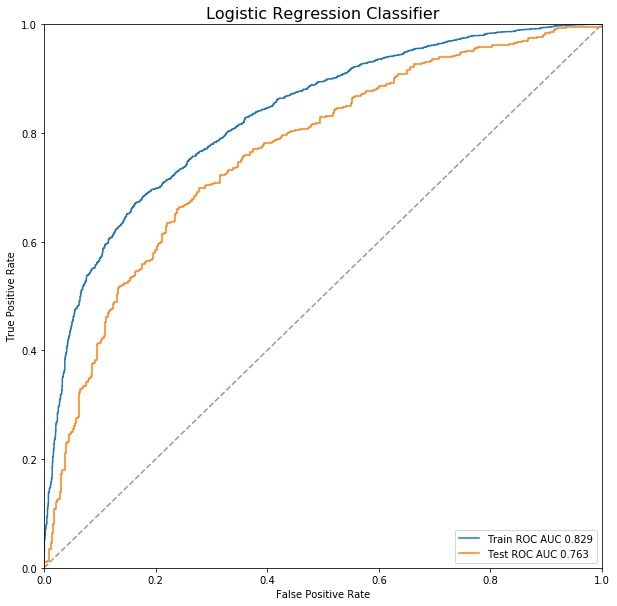

In [86]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [88]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 3)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 3)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.954
Test:  0.826


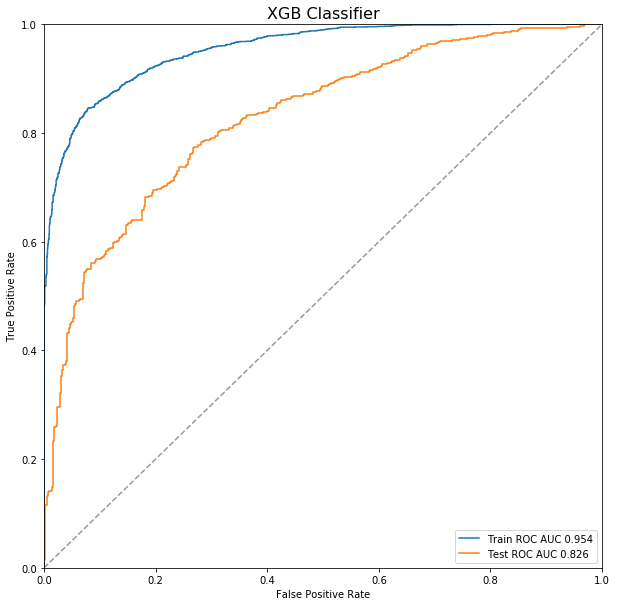

In [89]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    